0001083642 - Kankana Ghosh - kankana.ghosh@studio.unibo.it 

0001120390 - Valeria Izvoreanu - valeria.izvoreanu@studio.unibo.it

0001026226 - Sara Vorabbi - sara.vorabbi@studio.unibo.it

# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [1]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6559, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 6559 (delta 45), reused 35 (delta 35), pack-reused 6293 (from 1)
Receiving objects: 100% (6559/6559), 116.26 MiB | 34.79 MiB/s, done.
Resolving deltas: 100% (275/275), done.
Updating files: 100% (5717/5717), done.


In [2]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple
import copy
import pandas as pd

import matplotlib.pyplot as plt
import cv2
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim # Import the optim module

from IPython.display import Markdown, display

def display_markdown(markdown_text: str):
    display(Markdown(markdown_text))

In [3]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

## Part 1: Solution

The first thing we do is visualize the images in the dataset and printing the shape of the images to understand if there is the need to do some pre-processing of the data.

Image size: (348, 348, 3)
Package: Juice


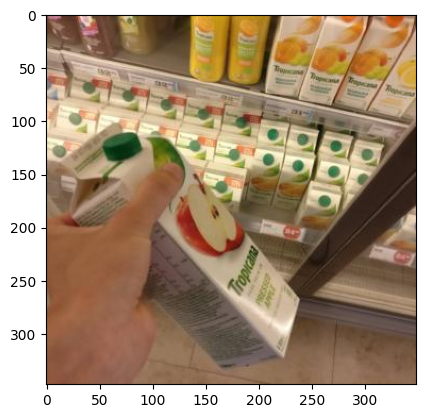

In [4]:
img_path = '/content/GroceryStoreDataset/dataset/train/Packages/Juice/Tropicana-Apple-Juice/Tropicana-Apple-Juice_011.jpg'

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

print("Image size:", img.shape)
print("Package: Juice")

Image size: (348, 348, 3)
Vegetable: Carrot


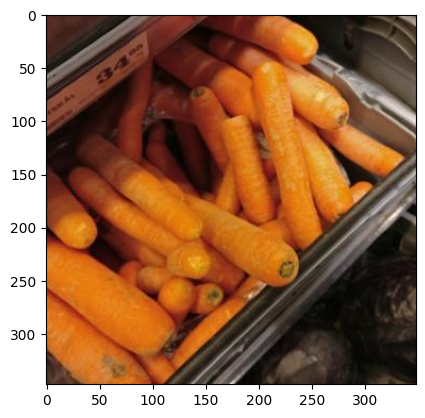

In [5]:
img_path = '/content/GroceryStoreDataset/dataset/train/Vegetables/Carrots/Carrots_022.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

print("Image size:", img.shape)
print("Vegetable: Carrot")

Image size: (348, 348, 3)
Fruit: Pineapple


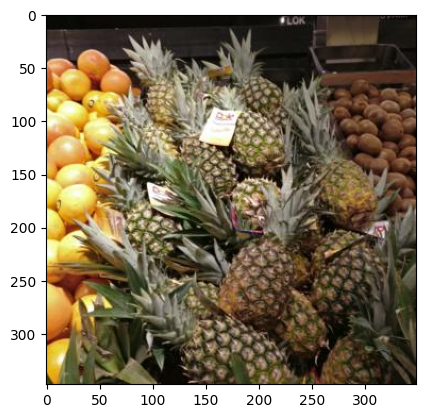

In [6]:
img_path = '/content/GroceryStoreDataset/dataset/train/Fruit/Pineapple/Pineapple_007.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

print("Image size:", img.shape)
print("Fruit: Pineapple")

In [4]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We resize the images of the dataset to a fixed size, 224x224 pixels, and create the datatset and dataloader instances.

In [5]:
# Define transform to resizes each image to a fixed size of 224x224 px
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create the Dataset instances
train_dataset = GroceryStoreDataset(split='train', transform=transform)
val_dataset = GroceryStoreDataset(split='val', transform=transform)
test_dataset = GroceryStoreDataset(split='test', transform=transform)

# Create Data Loader instances
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
# Function to print dataset shapes
def print_dataset_shapes(loader, split_name):
    for i, (images, labels) in enumerate(loader):
        print(f"{split_name} - Batch {i+1}")
        print(f"Images shape: {images.shape}")
        print(f"Labels shape: {labels.shape}")
        break   # Print only the first batch shapes

# Printing shapes of the datasets
print_dataset_shapes(train_loader, "Train")
print_dataset_shapes(val_loader, "Validation")
print_dataset_shapes(test_loader, "Test")
classes = train_dataset.get_num_classes()
print(f"Number of classes: {classes}")

Train - Batch 1
Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Validation - Batch 1
Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Test - Batch 1
Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Number of classes: 43


### Loss and Accuracy Plot function

We define the function used to plot the losses and the accuracies of the validation set for multiple models across epochs.

In [7]:
def plot_metrics(metrics):
    # Plot val_losses for all models
    plt.figure(figsize=(10, 6))
    for index, row in df_metrics.iterrows():
        plt.plot(row['val_losses'], label=row['model_name'])

    plt.title('Validation Losses for All Models')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.show()

    # Plot val_accuracies for all models
    plt.figure(figsize=(10, 6))
    for index, row in df_metrics.iterrows():
        plt.plot(row['val_accuracies'], label=row['model_name'])

    plt.title('Validation Accuracies for All Models')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.show()

### Train and Evaluate function

#### Training function

In this section we define the function used to train the model. Following we proceed by outlining the training process for the convolutional neural network models by breaking down the key hyperparameters and techniques used:

- **Loss Function**: we employed `CrossEntropyLoss` as loss function, since it is best suited for multi-class classification problems.
It measures the difference between the predicted probability distribution and the true target distribution.
- **Optimizer**: we choose `AdamW` as the optimizer, a variant of the Adam optimizer that incorporates weight decay into the parameter update rule to improve the generalization performance of deep learning models.
- **Learning Rate**: we set the initial value to `1e-4 (0.0001)`, this value will be adjusted during training by the learning rate scheduler.
- **Weight decay**: like for the learning rate, the initial value is `1e-4 (0.0001)`.
- **Scheduler**: we used the `StepLR` that reduces the learning rate by a gamma factor of 0.1 every step_size epochs (7 in our case). It should help the model to converge better avoiding overfitting.
- **Early Stopping**: is employed with a patience of `7` epochs. If the validation loss fails to improve for 7 consecutive epochs, training terminates to prevent overfitting.

- **Training and Validation**: we implemented  the function such that it iterates through a number of epochs equals to 30. Each epoch involves training the model on the training data (`train_loader`) and evaluating its performance on the validation data (`val_loader`).

- **Metrics Tracking**: the function tracks and stores training and validation *loss* and *accuracy* for each epoch. This allow us to monitor the model's performance during training and can help us in identifying overfitting or underfitting

- **Best Model Selection**: during training, the model with the lowest validation loss is identified and saved as the "best model". After the training, the model's weights are restored to this "best version", ensuring the selection of the model that performs best on unseen data (validation set)

In [11]:
def train_model(model, train_loader, val_loader, num_epochs=30, patience=7):
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = StepLR(optimizer, step_size=7, gamma=0.1)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    early_stop_counter = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):

        # Initialize metrics for this epoch
        epoch_train_loss = 0.0
        epoch_train_acc = 0.0
        epoch_val_loss = 0.0
        epoch_val_acc = 0.0

        # Training phase
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset)

        # Validation phase
        model.eval()   # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = running_corrects.double() / len(val_loader.dataset)

        # Print metrics
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | '
              f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        # Save losses and accuracies
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc.item())
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc.item())

        # Deep copy the model if validation accuracy improves
        if epoch_val_loss <= best_loss:
            best_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        # Early stopping
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

        # Step the scheduler
        scheduler.step()

    print(f'Minimun val loss: {best_loss:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accuracies, val_losses, val_accuracies

#### Evaluation function on the Test Set

In the following cell we define the function that we use to evaluate model on the test set.

In [7]:
def evaluate_model(model):
	criterion = nn.CrossEntropyLoss()

	# Evaluate the model
	model.eval()
	test_running_loss = 0.0
	correct = 0
	total = 0
	with torch.no_grad():
		for images, labels in test_loader:
			images, labels = images.to(device), labels.to(device)

			outputs = model(images)
			loss = criterion(outputs, labels)
			test_running_loss += loss.item() * images.size(0)

			_, predicted = torch.max(outputs, 1)
			total += labels.size(0)
			correct += (predicted == labels).sum().item()

	test_loss = test_running_loss / len(test_loader.dataset)
	test_accuracy = 100 * correct / total
	display_markdown(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

### 1. First attempt: ConvNet

The starting point of our experimentation is to build a neural network, that will serve as a baseline, using four different type of layers: Convolution, Activation Functions, Pooling or Sub Sampling and Classification or Fully Connected Layer.

Below we outline the structure of the network:
- we start by employing four **convolutional Layer** (Conv1 to Conv4) that extract features at different levels of abstraction
- each convolutional layer is followed by a **ReLU** (Rectified Linear Unit) activation that adds non-linearity and a **Max Pooling** layer used for dimensionality reduction
- at the end of the network we place two **fully-connected layers** (FC1 and FC2) are used for the classification of the extracted features. In our specific case FC1 performs feature learning while FC2 acts as the output layer, with a number of neurons equal to the number of classes, specifically 43

The model ends up having ~13 millions parameters. It was compiled and fit *without any data augmentation* and *regularization* and manages to achieve a **validation accuracy of 17%**.



In [15]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=3):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, 128 * 14 * 14)  # Flattenning the tensor
        x = F.relu(self.fc1(x))

        return x


model = ConvNet(classes).to(device)

# Print the model summary
summary(model, input_size=(3, 224, 224), device="cuda" if torch.cuda.is_available() else "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
         MaxPool2d-2         [-1, 32, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]          18,496
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]          73,856
         MaxPool2d-6          [-1, 128, 28, 28]               0
            Conv2d-7          [-1, 128, 28, 28]         147,584
         MaxPool2d-8          [-1, 128, 14, 14]               0
            Linear-9                  [-1, 512]      12,845,568
Total params: 13,086,400
Trainable params: 13,086,400
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 27.76
Params size (MB): 49.92
Estimated Total Size (MB): 78.25
----------------------------------

In [ ]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader)

Epoch [1/30], Train Loss: 5.1623 Acc: 0.0962 | Val Loss: 5.1556 Acc: 0.1385
Epoch [2/30], Train Loss: 4.6834 Acc: 0.1902 | Val Loss: 5.0767 Acc: 0.1149
Epoch [3/30], Train Loss: 4.4907 Acc: 0.2367 | Val Loss: 4.9571 Acc: 0.1655
Epoch [4/30], Train Loss: 4.3198 Acc: 0.2674 | Val Loss: 4.9082 Acc: 0.1486
Epoch [5/30], Train Loss: 4.1889 Acc: 0.2981 | Val Loss: 4.9253 Acc: 0.1520
Epoch [6/30], Train Loss: 4.0681 Acc: 0.3265 | Val Loss: 4.9218 Acc: 0.1351
Epoch [7/30], Train Loss: 3.9952 Acc: 0.3496 | Val Loss: 4.8743 Acc: 0.1655
Epoch [8/30], Train Loss: 3.8546 Acc: 0.3917 | Val Loss: 4.7724 Acc: 0.1791
Epoch [9/30], Train Loss: 3.8296 Acc: 0.3951 | Val Loss: 4.7786 Acc: 0.1655
Epoch [10/30], Train Loss: 3.8165 Acc: 0.3962 | Val Loss: 4.7889 Acc: 0.1791
Epoch [11/30], Train Loss: 3.8066 Acc: 0.4008 | Val Loss: 4.7804 Acc: 0.1791
Epoch [12/30], Train Loss: 3.7944 Acc: 0.4008 | Val Loss: 4.8040 Acc: 0.1723
Epoch [13/30], Train Loss: 3.7849 Acc: 0.4027 | Val Loss: 4.8171 Acc: 0.1824
Epoch [1

In [ ]:
metrics = []
metrics.append({
    "model_name": "ConvNet",
    "train_losses": train_losses,
    "train_accuracies": train_accuracies,
    "val_losses": val_losses,
    "val_accuracies": val_accuracies
})

### Data Augmentation

Due to small training data size and lack of variations of a particular type of image, the model does not seem to be learning. Therefore, to add more diverse data to the dataset we use data augmentation.

Using the `torchvision.transforms.Compose` module in PyTorch to compose several transforms together. We define the transformations to include rescaling, shearing, zooming, and horizontal flipping:
- All images resized to a fixed size of 224x224 pixels.
- Shear_range applied random shear transfromations
- Zoom_range randomly zooms inside image
- Horizontal_flip is set to True, which flips the images horizontally
- Normalizing

Despite these changes, training the CovNet on the Augmented Data produced no/negligible improvement.

In [ ]:
# Defining transformations for training dataset
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing to 224x224
    transforms.ToTensor(),  # Converting to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalizing
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomAffine(degrees=0, shear=0.2),  # Shear transformation
    transforms.RandomApply([transforms.RandomResizedCrop(224, scale=(0.8, 1.0))], p=0.5),  # Random zoom
])

# Defining transformations for validation dataset
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing to 224x224
    transforms.ToTensor(),  # Converting to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalizing
])

# Creating dataset instances
train_dataset = GroceryStoreDataset(split='train', transform=train_transform)
val_dataset = GroceryStoreDataset(split='val', transform=val_test_transform)
test_dataset = GroceryStoreDataset(split='test', transform=val_test_transform)

# Creating data loader instances
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### 2. Second attempt: ConvNet_BN

- Building upon the basic architecture of ConvNet, utilizing **five convolutional layers** (Conv1 to Conv5) for feature extraction.
- Similar to ConvNet, each convolutional layer is followed by a **ReLU** activation for non-linearity. However, introducing a key improvement by incorporating **Batch Normalization** (BN) layers (BN1 to BN5) after each convolutional layer.
  * Incorporating Batch Normalization, helps address the problem of vanishing/exploding gradients during training, leading to more stable learning and potentially better generalization.
- The model employs **Max Pooling** layers for dimensionality reduction after each convolutional layer, similar to ConvNet.
- Two fully-connected layers (FC1 and FC2) are used for classification, followed by a final output layer (FC3) with the number of neurons equal to the number of classes (43).
- **Dropout** layers (with a probability of 0.5) are introduced after the fully-connected layers to prevent overfitting.
 	* Dropout layers are introduced to randomly drop neurons during training, preventing the model from memorizing training data and promoting better performance on unseen data (validation set).
- The model has ~27 millions parameters.
- **Limitations**: While achieving a significant improvement over ConvNet, **47% validation accuracy** still indicate room for improvement.




In [ ]:
class ConvNet_BN(nn.Module):
    def __init__(self, num_classes=43):
        super(ConvNet_BN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(p=0.5)

        self.fc1 = nn.Linear(512 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))

        x = x.view(-1, 512 * 7 * 7)  # Flattening the tensor
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

In [ ]:
model1 = ConvNet_BN(classes).to(device)

# Print the model summary
summary(model1, input_size=(3, 224, 224), device="cuda" if torch.cuda.is_available() else "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
       BatchNorm2d-5         [-1, 64, 112, 112]             128
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
       BatchNorm2d-8          [-1, 128, 56, 56]             256
         MaxPool2d-9          [-1, 128, 28, 28]               0
           Conv2d-10          [-1, 256, 28, 28]         295,168
      BatchNorm2d-11          [-1, 256, 28, 28]             512
        MaxPool2d-12          [-1, 256, 14, 14]               0
           Conv2d-13          [-1, 512, 14, 14]       1,180,160
      BatchNorm2d-14          [-1, 512,

In [ ]:
model1, train_losses1, train_accuracies1, val_losses1, val_accuracies1 = train_model(model1, train_loader, val_loader, num_epochs = 45)

Epoch [1/45], Train Loss: 3.2725 Acc: 0.1591 | Val Loss: 2.9112 Acc: 0.2196
Epoch [2/45], Train Loss: 2.6971 Acc: 0.2610 | Val Loss: 2.6663 Acc: 0.3041
Epoch [3/45], Train Loss: 2.3354 Acc: 0.3330 | Val Loss: 2.3342 Acc: 0.3615
Epoch [4/45], Train Loss: 2.0183 Acc: 0.4155 | Val Loss: 2.2689 Acc: 0.3378
Epoch [5/45], Train Loss: 1.7917 Acc: 0.4735 | Val Loss: 2.1309 Acc: 0.3784
Epoch [6/45], Train Loss: 1.6045 Acc: 0.5167 | Val Loss: 1.9802 Acc: 0.4223
Epoch [7/45], Train Loss: 1.4622 Acc: 0.5496 | Val Loss: 1.8411 Acc: 0.4899
Epoch [8/45], Train Loss: 1.2405 Acc: 0.6167 | Val Loss: 1.8891 Acc: 0.4392
Epoch [9/45], Train Loss: 1.1693 Acc: 0.6314 | Val Loss: 1.7770 Acc: 0.4561
Epoch [10/45], Train Loss: 1.1317 Acc: 0.6402 | Val Loss: 1.8505 Acc: 0.4426
Epoch [11/45], Train Loss: 1.1105 Acc: 0.6508 | Val Loss: 1.8928 Acc: 0.4358
Epoch [12/45], Train Loss: 1.0790 Acc: 0.6508 | Val Loss: 1.7680 Acc: 0.4764
Epoch [13/45], Train Loss: 1.0615 Acc: 0.6614 | Val Loss: 1.7162 Acc: 0.4831
Epoch [1

In [ ]:
display_markdown("# ConvNet_BN Test Set Accuracy")
evaluate_model(model1)

# ConvNet_BN Test Set Accuracy

Test Loss: 1.2804, Test Accuracy: 60.24%

In [ ]:
metrics.append({
    "model_name": "ConvNet_BN",
    "train_losses": train_losses1,
    "train_accuracies": train_accuracies1,
    "val_losses": val_losses1,
    "val_accuracies": val_accuracies1
})

### 3. Final attempt: ConvNet_res

**Model Architecture**:

ConvNet_res builds upon the foundation of ConvNet_BN by incorporating several improvements:

- **Residual Block**: It introduces a residual block (res_block1) after the convolutional layers. Residual blocks help address the vanishing gradient problem in deeper networks, allowing the model to learn more complex features from the data.
- **Global Average Pooling**: Instead of flattening the entire feature map, ConvNet_res employs Global Average Pooling. This reduces the number of parameters in the fully-connected layers and can improve generalization.
- A **batch normalization** layer after the fully connected layer provides better regularization and helps converge better.
- Removing the last conv5 layer reduced overfitting.

**Advantages over Previous Models**:

- Improved Feature Learning: The combination of increased network depth (similar to ConvNet_BN) and the residual block allows ConvNet_res to learn more complex and robust features from the grocery images.
- Reduced Overfitting: Global Average Pooling helps reduce the number of parameters in the fully-connected layers, potentially mitigating overfitting.
- Higher Validation Accuracy: `ConvNet_res achieves a significantly higher validation accuracy (60.8%) compared to ConvNet (17.5%) and ConvNet_BN (47.6%)`, demonstrating the effectiveness of the implemented improvements.

**Limitations**:

- While achieving the best accuracy among the three models, **60.8% validation accuracy** still indicate room for improvement, especially considering the complexity of the 43-class classification task.
- Training a model from scratch, like ConvNet_res, requires a substantial amount of training data and computational resources. For datasets with a limited number of images, this can be a significant bottleneck.

In [ ]:
class ConvNet_res(nn.Module):
    def __init__(self, num_classes=43):
        super(ConvNet_res, self).__init__()

        # Convolutional layers with Batch Normalization
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Residual block
        self.res_block1 = self._make_residual_block(256, 256)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers
        self.fc1 = nn.Linear(256, 512)
        # self.fc2 = nn.Linear(512, 256)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, num_classes)

        # Dropout for regularization
        self.dropout = nn.Dropout(p=0.5)

        # Max Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def _make_residual_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        # Convolutional layers with Batch Normalization
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        # Residual block
        residual = x
        x = F.relu(self.res_block1(x) + residual)  # Residual connection with ReLU

        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)  # Flattenning for fully connected layers

        # Fully connected layers with dropout
        x = self.dropout(F.relu(self.bn_fc1(self.fc1(x))))
        x = self.fc3(x)

        return x

In [ ]:
model_res = ConvNet_res(classes).to(device)

# Print the model summary
summary(model_res, input_size=(3, 224, 224), device="cuda" if torch.cuda.is_available() else "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
       BatchNorm2d-5         [-1, 64, 112, 112]             128
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
       BatchNorm2d-8          [-1, 128, 56, 56]             256
         MaxPool2d-9          [-1, 128, 28, 28]               0
           Conv2d-10          [-1, 256, 28, 28]         295,168
      BatchNorm2d-11          [-1, 256, 28, 28]             512
        MaxPool2d-12          [-1, 256, 14, 14]               0
           Conv2d-13          [-1, 512, 14, 14]       1,180,160
      BatchNorm2d-14          [-1, 512,

In [ ]:
model2, train_losses2, train_accuracies2, val_losses2, val_accuracies2 = train_model(model_res, train_loader, val_loader, num_epochs = 45)

Epoch [1/45], Train Loss: 2.7753 Acc: 0.3000 | Val Loss: 2.5147 Acc: 0.3243
Epoch [2/45], Train Loss: 2.0119 Acc: 0.4697 | Val Loss: 2.2540 Acc: 0.3547
Epoch [3/45], Train Loss: 1.6019 Acc: 0.5712 | Val Loss: 2.0154 Acc: 0.4054
Epoch [4/45], Train Loss: 1.3416 Acc: 0.6572 | Val Loss: 1.7844 Acc: 0.4899
Epoch [5/45], Train Loss: 1.1382 Acc: 0.7133 | Val Loss: 1.7044 Acc: 0.5135
Epoch [6/45], Train Loss: 0.9699 Acc: 0.7682 | Val Loss: 1.5718 Acc: 0.5439
Epoch [7/45], Train Loss: 0.8450 Acc: 0.8053 | Val Loss: 1.4777 Acc: 0.5541
Epoch [8/45], Train Loss: 0.6889 Acc: 0.8534 | Val Loss: 1.3903 Acc: 0.5845
Epoch [9/45], Train Loss: 0.6423 Acc: 0.8663 | Val Loss: 1.3870 Acc: 0.6047
Epoch [10/45], Train Loss: 0.5985 Acc: 0.8951 | Val Loss: 1.4036 Acc: 0.5811
Epoch [11/45], Train Loss: 0.5827 Acc: 0.8917 | Val Loss: 1.3659 Acc: 0.5811
Epoch [12/45], Train Loss: 0.5592 Acc: 0.8977 | Val Loss: 1.3884 Acc: 0.6014
Epoch [13/45], Train Loss: 0.5578 Acc: 0.8947 | Val Loss: 1.3862 Acc: 0.5946
Epoch [1

In [ ]:
display_markdown("# ConvNet_res Test Set Accuracy")
evaluate_model(model2)

# ConvNet_res Test Set Accuracy

Test Loss: 1.2156, Test Accuracy: 61.53%

In [ ]:
df_metrics = pd.DataFrame(metrics)

In [ ]:
metrics.append({
    "model_name": "ConvNet_res",
    "train_losses": train_losses2,
    "train_accuracies": train_accuracies2,
    "val_losses": val_losses2,
    "val_accuracies": val_accuracies2
})

### Plotting the Validation Losses and Accuracies

We proceed by plotting the values of the loss and accuracy for the three model in order to compare the results.

## Comparison plot (with early stopping)

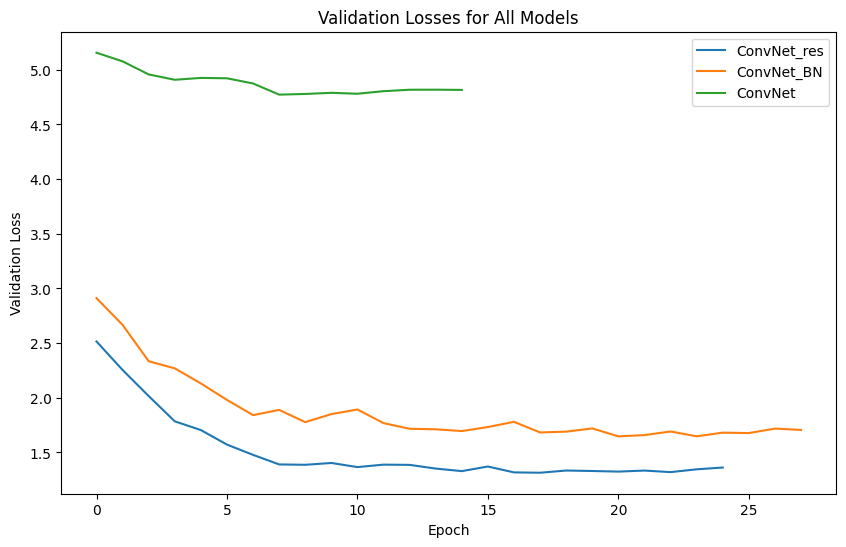

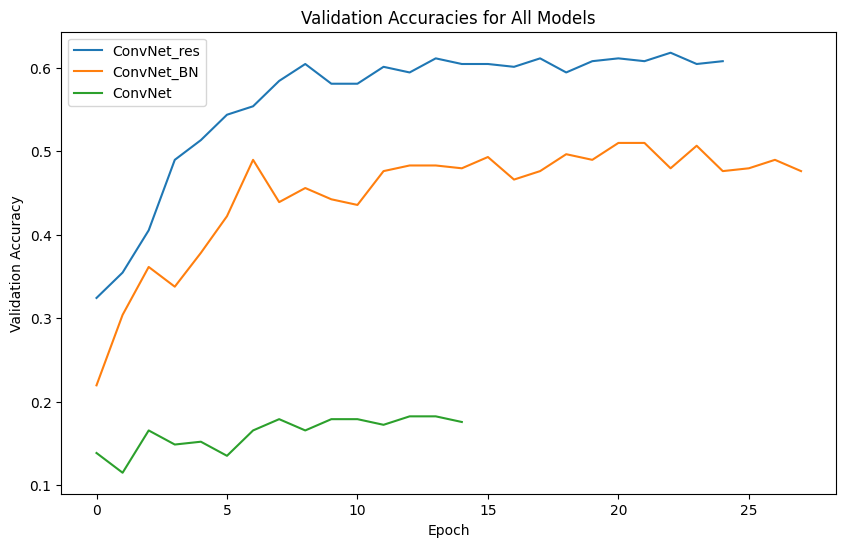

In [ ]:
display_markdown("## Comparison plot (with early stopping)")
plot_metrics(metrics)

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

In [8]:
from typing import Optional

from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

from torchvision.models import resnet18, ResNet18_Weights

Here we define the function that we are going to use to freeze the layers of the ResNet18 so that we can prevent its weights from being updated during training.

In [ ]:
# Freeze the layer given as input if train=False
def set_requires_grad(layer: torch.nn.Module, train: bool) -> None:
    for p in layer.parameters():
        p.requires_grad = train

### 1. First attempt: `resnet18_base`

In the first attempt we loads a pre-trained ResNet-18 model from the PyTorch's torchvision library, specifing that it should be pre-trained on the ImageNet dataset.

We replace the final fully connected layer with **a new linear layer** that has the number of output features equal to the number of classes in the dataset.

To train this model we use the function `train_model` from Part 1 of the assignment with the same training hyperparameters used to find the best modelin the previous part.

The model achieve a **validation accuracy of 50%**.

In [9]:
num_classes = train_dataset.get_num_classes()

fine_tuned_model = resnet18(weights='IMAGENET1K_V1').to(device)

# Override the old classifier by adding a linear layer
fine_tuned_model.fc = nn.Linear(fine_tuned_model.fc.in_features, num_classes).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 175MB/s]


We **freeze** all the layers of the ResNet-18 model except for the final fully connected layer. This is done in order to exploit all the knowledge the model has already acquired from the training on the original ImageNet dataset. In this way the model should also generalize better and converge faster on our new task.

The number of parameter that we are training is 22,059.

In [ ]:
set_requires_grad(fine_tuned_model.conv1, False)
set_requires_grad(fine_tuned_model.bn1, False)
set_requires_grad(fine_tuned_model.layer1, False)
set_requires_grad(fine_tuned_model.layer2, False)
set_requires_grad(fine_tuned_model.layer3, False)
set_requires_grad(fine_tuned_model.layer4, False)

summary(fine_tuned_model, input_size=(3, 224, 224), device="cuda" if torch.cuda.is_available() else "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(fine_tuned_model, train_loader, val_loader, num_epochs = 50)

Epoch [1/50], Train Loss: 3.1444 Acc: 0.1924 | Val Loss: 3.0084 Acc: 0.1892
Epoch [2/50], Train Loss: 2.6436 Acc: 0.3076 | Val Loss: 2.7658 Acc: 0.2331
Epoch [3/50], Train Loss: 2.3578 Acc: 0.3932 | Val Loss: 2.5443 Acc: 0.3007
Epoch [4/50], Train Loss: 2.1323 Acc: 0.4557 | Val Loss: 2.3816 Acc: 0.3547
Epoch [5/50], Train Loss: 1.9340 Acc: 0.5367 | Val Loss: 2.2098 Acc: 0.3818
Epoch [6/50], Train Loss: 1.7644 Acc: 0.5970 | Val Loss: 2.0909 Acc: 0.4426
Epoch [7/50], Train Loss: 1.6254 Acc: 0.6405 | Val Loss: 1.9949 Acc: 0.4595
Epoch [8/50], Train Loss: 1.5373 Acc: 0.6830 | Val Loss: 1.9714 Acc: 0.4797
Epoch [9/50], Train Loss: 1.5235 Acc: 0.6867 | Val Loss: 1.9558 Acc: 0.4730
Epoch [10/50], Train Loss: 1.5015 Acc: 0.6848 | Val Loss: 1.9579 Acc: 0.4797
Epoch [11/50], Train Loss: 1.5026 Acc: 0.6879 | Val Loss: 1.9388 Acc: 0.4899
Epoch [12/50], Train Loss: 1.4836 Acc: 0.6973 | Val Loss: 1.9422 Acc: 0.4865
Epoch [13/50], Train Loss: 1.4630 Acc: 0.7064 | Val Loss: 1.9241 Acc: 0.4899
Epoch [1

In [ ]:
display_markdown("## resnet18_base Test Set Accuracy")
evaluate_model(model)

## resnet18_base Test Set Accuracy

Test Loss: 1.7402, Test Accuracy: 57.55%

We can see how the accuracy on the test set is not satisfactory. We will try to improve our network by tweaking the hyperparameters and making some changes to the training function `train_model` in the following sections of the notebook.

In [ ]:
metrics =[]
metrics.append({
    "model_name": "resnet18_base",
    "train_losses": train_losses,
    "train_accuracies": train_accuracies,
    "val_losses": val_losses,
    "val_accuracies": val_accuracies
})

### Update of `train_model` and hyperparameters

Since we could not reach a satisfacory performance, we decided to make minor changes to the `train_model` fuction and to tweak the hyperparameters in order to increase the accuracy on the validation split of GroceryStoreDataset.

In this part of the notebook we decided to use a dictionary, `cfg`, to store the hyperparameters, in this way updating the hyperparameters over the course of the various tests is more immediate.


In [22]:
cfg = {
    "resize_size": 256,
    "crop_size": 224,

    "batch_size": 32,
    "num_epochs": 25,

    "lr": 3e-4,
    "wd": 1e-4,
    "step_size": 5
}

In the following training function we switched to the `OneCycleLR` **scheduler**, designed to automatically adjust the learning rate throughout training in one cycle. This approach can lead to faster convergence and potentially improve performance.

The second change made is the removal of **early stopping**, since we wanted the possibility of exploring a wider range of hyperparameter settings without the risk of prematurely stopping training.

In [26]:
def train_model(model, train_loader, val_loader, num_epochs=30, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"])
    num_steps = num_epochs * len(train_loader)
    scheduler = OneCycleLR(optimizer, cfg["lr"], total_steps=num_steps)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    early_stop_counter = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Initialize metrics for this epoch
        epoch_train_loss = 0.0
        epoch_train_acc = 0.0
        epoch_val_loss = 0.0
        epoch_val_acc = 0.0

        # Training phase
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset)

        # Validation phase
        model.eval()   # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = running_corrects.double() / len(val_loader.dataset)

        # Print metrics
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | '
              f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        # Record losses and accuracies
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc.item())
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc.item())

        # Deep copy the model if validation accuracy improves
        if epoch_val_loss <= best_loss:
            best_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        # Step the scheduler
        scheduler.step()

    print(f'Minimun val loss: {best_loss:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accuracies, val_losses, val_accuracies

### 2. Second attempt: `resnet18_base2`

After updating the hyperparameters and the function `train_model` we proceed with the training of the same network defined in Section *First attempt: `resnet18_base`*, to check if there is some improvement.

For the hyperparameters we use a `lr = 3e-3`.

In [ ]:
num_classes = train_dataset.get_num_classes()

fine_tuned_model_2 = resnet18(weights='IMAGENET1K_V1').to(device)

fine_tuned_model_2.fc = nn.Linear(fine_tuned_model_2.fc.in_features, num_classes).to(device)

In [ ]:
set_requires_grad(fine_tuned_model_2.conv1, False)
set_requires_grad(fine_tuned_model_2.bn1, False)
set_requires_grad(fine_tuned_model_2.layer1, False)
set_requires_grad(fine_tuned_model_2.layer2, False)
set_requires_grad(fine_tuned_model_2.layer3, False)
set_requires_grad(fine_tuned_model_2.layer4, False)

summary(fine_tuned_model_2, input_size=(3, 224, 224), device="cuda" if torch.cuda.is_available() else "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
model_new, train_losses_new, train_accuracies_new, val_losses_new, val_accuracies_new = train_model(fine_tuned_model_2, train_loader, val_loader, num_epochs = 35)

Epoch [1/35], Train Loss: 0.6796 Acc: 0.8617 | Val Loss: 0.7913 Acc: 0.7669
Epoch [2/35], Train Loss: 0.0908 Acc: 0.9917 | Val Loss: 0.6142 Acc: 0.8176
Epoch [3/35], Train Loss: 0.0273 Acc: 0.9992 | Val Loss: 0.5538 Acc: 0.8142
Epoch [4/35], Train Loss: 0.0121 Acc: 0.9996 | Val Loss: 0.5473 Acc: 0.8176
Epoch [5/35], Train Loss: 0.0104 Acc: 0.9996 | Val Loss: 0.5004 Acc: 0.8412
Epoch [6/35], Train Loss: 0.0071 Acc: 1.0000 | Val Loss: 0.4907 Acc: 0.8277
Epoch [7/35], Train Loss: 0.0075 Acc: 0.9992 | Val Loss: 0.8402 Acc: 0.7838
Epoch [8/35], Train Loss: 0.0165 Acc: 0.9970 | Val Loss: 0.6400 Acc: 0.8142
Epoch [9/35], Train Loss: 0.0144 Acc: 0.9981 | Val Loss: 0.5974 Acc: 0.8074
Epoch [10/35], Train Loss: 0.0147 Acc: 0.9977 | Val Loss: 0.6675 Acc: 0.8142
Epoch [11/35], Train Loss: 0.0064 Acc: 0.9996 | Val Loss: 0.4507 Acc: 0.8581
Epoch [12/35], Train Loss: 0.0032 Acc: 1.0000 | Val Loss: 0.4805 Acc: 0.8480
Epoch [13/35], Train Loss: 0.0024 Acc: 1.0000 | Val Loss: 0.4564 Acc: 0.8581
Epoch [1

In [ ]:
display_markdown("## resnet18_base2 Test Set Accuracy")
evaluate_model(model_new)

## resnet18_base2 Test Set Accuracy

Test Loss: 0.5304, Test Accuracy: 86.52%

It seems that we reach a high accuracy percentage in the validation split, but having a look at the loss we can see that the values jump around without a steadily decrease. This version does not seem to be stable so we decide to proceed with other experimentations.

In [ ]:
metrics.append({
    "model_name": "resnet18_base2",
    "train_losses": train_losses_new,
    "train_accuracies": train_accuracies_new,
    "val_losses": val_losses_new,
    "val_accuracies": val_accuracies_new
})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
save_path = '/content/drive/MyDrive/AssignmentsIPCV/best_model_weights.pth'

# Save the model state dictionary (weights)
torch.save(model_new.state_dict(), save_path)

### 3. Third attempt: `resnet18_base_added_linear_layers`

At this point we decided to change slightly the structure of the network by **adding another linear layer**. This increases the number of parameters in the model, giving it more capacity to learn complex patterns in the data. Moreover the additional linear layer can help to extract more meaningful features from the output of the ResNet18 backbone.

Training this network we found  that the optimal numbers of **epochs** was `35` and we choose a **learning rate** equals to `1e-4`.

**N.B.** This cell defines the final version of the neural network that manages to achieve the best result. Throughout the project we modified this architecture, by commenting, uncommenting and adding different lines of code, specifically layers.

For instance, later on we try a version with dropout and we added it in this cell of code.

In [ ]:
num_classes = train_dataset.get_num_classes()

fine_tuned_model = resnet18(weights='IMAGENET1K_V1').to(device)

fine_tuned_model.fc = nn.Sequential(nn.Linear(fine_tuned_model.fc.in_features, 768),    # First additional layer
                                    nn.ReLU(),
                                    nn.Dropout(p = 0.6),                                # Activation function
                                    nn.Linear(768, 256),                                # Second additional layer
                                    nn.ReLU(),                                          # Activation function
                                    nn.Linear(256, num_classes)                         # Final layer to output num_classes
                                    ).to(device)

In [ ]:
set_requires_grad(fine_tuned_model.conv1, False)
set_requires_grad(fine_tuned_model.bn1, False)
set_requires_grad(fine_tuned_model.layer1, False)
set_requires_grad(fine_tuned_model.layer2, False)
set_requires_grad(fine_tuned_model.layer3, False)
set_requires_grad(fine_tuned_model.layer4, False)

summary(fine_tuned_model, input_size=(3, 224, 224), device="cuda" if torch.cuda.is_available() else "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
model1, train_losses1, train_accuracies1, val_losses1, val_accuracies1 = train_model(fine_tuned_model, train_loader, val_loader, num_epochs = 35)

Epoch [1/35], Train Loss: 3.7251 Acc: 0.0845 | Val Loss: 3.6981 Acc: 0.0946
Epoch [2/35], Train Loss: 3.6646 Acc: 0.1455 | Val Loss: 3.6429 Acc: 0.1757
Epoch [3/35], Train Loss: 3.6019 Acc: 0.1958 | Val Loss: 3.5880 Acc: 0.1993
Epoch [4/35], Train Loss: 3.5379 Acc: 0.2235 | Val Loss: 3.5262 Acc: 0.2095
Epoch [5/35], Train Loss: 3.4702 Acc: 0.2383 | Val Loss: 3.4685 Acc: 0.2027
Epoch [6/35], Train Loss: 3.4005 Acc: 0.2360 | Val Loss: 3.4108 Acc: 0.1959
Epoch [7/35], Train Loss: 3.3343 Acc: 0.2258 | Val Loss: 3.3517 Acc: 0.1892
Epoch [8/35], Train Loss: 3.2700 Acc: 0.2125 | Val Loss: 3.3044 Acc: 0.1926
Epoch [9/35], Train Loss: 3.2107 Acc: 0.2170 | Val Loss: 3.2624 Acc: 0.1926
Epoch [10/35], Train Loss: 3.1528 Acc: 0.2148 | Val Loss: 3.2161 Acc: 0.1926
Epoch [11/35], Train Loss: 3.1006 Acc: 0.2201 | Val Loss: 3.1703 Acc: 0.1926
Epoch [12/35], Train Loss: 3.0470 Acc: 0.2159 | Val Loss: 3.1332 Acc: 0.1993
Epoch [13/35], Train Loss: 2.9921 Acc: 0.2405 | Val Loss: 3.0926 Acc: 0.2061
Epoch [1

In [ ]:
display_markdown("## resnet18_added linear layers: Test Set Accuracy")
evaluate_model(model1)

## resnet18_added linear layers: Test Set Accuracy

Test Loss: 2.1876, Test Accuracy: 48.57%

The model achieve a **validation accuracy of 41%**. Even if the accuracy is lower compared to all the previous attempts, here the decrease in loss is constant, meaning the if trained more it could reach a better result. In the next section we are going to add other regularization techniques to try and get a better result.


In [ ]:
metrics.append({
    "model_name": "resnet18_added linear layers",
    "train_losses": train_losses1,
    "train_accuracies": train_accuracies1,
    "val_losses": val_losses1,
    "val_accuracies": val_accuracies1
})

### 4. Fourth attempt: `resnet18_base_added dropout`

In this attempt we lower the learning rate to `lr = 1e-4`, in this way we try to have a steady convergence. We also add `Dropout(p=0.6)`, meaning that we randomly drop out neurons during training. In fact, randomly deactivated neaurons during each training iteration, force the network to learn more robust and independent representations of the data.

In [ ]:
model2, train_losses2, train_accuracies2, val_losses2, val_accuracies2 = train_model(fine_tuned_model, train_loader, val_loader, num_epochs = 35)

Epoch [1/35], Train Loss: 3.7776 Acc: 0.0314 | Val Loss: 3.7435 Acc: 0.0405
Epoch [2/35], Train Loss: 3.7097 Acc: 0.0545 | Val Loss: 3.6838 Acc: 0.1385
Epoch [3/35], Train Loss: 3.6322 Acc: 0.1398 | Val Loss: 3.6227 Acc: 0.2804
Epoch [4/35], Train Loss: 3.5554 Acc: 0.2121 | Val Loss: 3.5480 Acc: 0.2466
Epoch [5/35], Train Loss: 3.4599 Acc: 0.2758 | Val Loss: 3.4671 Acc: 0.2432
Epoch [6/35], Train Loss: 3.3342 Acc: 0.2875 | Val Loss: 3.3619 Acc: 0.2365
Epoch [7/35], Train Loss: 3.1913 Acc: 0.2803 | Val Loss: 3.2507 Acc: 0.2331
Epoch [8/35], Train Loss: 3.0347 Acc: 0.2841 | Val Loss: 3.1130 Acc: 0.2297
Epoch [9/35], Train Loss: 2.8897 Acc: 0.2871 | Val Loss: 2.9949 Acc: 0.2399
Epoch [10/35], Train Loss: 2.7356 Acc: 0.2932 | Val Loss: 2.8905 Acc: 0.2399
Epoch [11/35], Train Loss: 2.6152 Acc: 0.3125 | Val Loss: 2.7939 Acc: 0.2534
Epoch [12/35], Train Loss: 2.4972 Acc: 0.3386 | Val Loss: 2.6769 Acc: 0.2703
Epoch [13/35], Train Loss: 2.4024 Acc: 0.3792 | Val Loss: 2.5860 Acc: 0.3412
Epoch [1

In [ ]:
display_markdown("## resnet18_added dropout: Test Set Accuracy")
evaluate_model(model2)

## resnet18_added dropout: Test Set Accuracy

Test Loss: 1.2041, Test Accuracy: 68.45%

We see a stable increase in the **validation accuracy** that manage to reach **60%**.

In [ ]:
metrics.append({
    "model_name": "resnet18_added dropout",
    "train_losses": train_losses2,
    "train_accuracies": train_accuracies2,
    "val_losses": val_losses2,
    "val_accuracies": val_accuracies2
})

### 5. Fifth attempt: `resnet18_base_best_lr` [BEST]

In the last attempt we try to speed up the training by changing again the **learning rate** from `1e-4` to `3-e4`.

In [ ]:
model3, train_losses3, train_accuracies3, val_losses3, val_accuracies3 = train_model(fine_tuned_model, train_loader, val_loader, num_epochs = 35)

Epoch [1/35], Train Loss: 3.6418 Acc: 0.1193 | Val Loss: 3.5571 Acc: 0.1655
Epoch [2/35], Train Loss: 3.3462 Acc: 0.1989 | Val Loss: 3.2727 Acc: 0.1723
Epoch [3/35], Train Loss: 2.9639 Acc: 0.2136 | Val Loss: 2.9726 Acc: 0.2162
Epoch [4/35], Train Loss: 2.6547 Acc: 0.3061 | Val Loss: 2.7251 Acc: 0.3446
Epoch [5/35], Train Loss: 2.3779 Acc: 0.4144 | Val Loss: 2.4881 Acc: 0.4054
Epoch [6/35], Train Loss: 2.1114 Acc: 0.4905 | Val Loss: 2.2899 Acc: 0.4358
Epoch [7/35], Train Loss: 1.9072 Acc: 0.5174 | Val Loss: 2.1535 Acc: 0.4493
Epoch [8/35], Train Loss: 1.7469 Acc: 0.5367 | Val Loss: 2.0594 Acc: 0.4628
Epoch [9/35], Train Loss: 1.6031 Acc: 0.5833 | Val Loss: 1.9759 Acc: 0.5068
Epoch [10/35], Train Loss: 1.4601 Acc: 0.6121 | Val Loss: 1.8508 Acc: 0.5236
Epoch [11/35], Train Loss: 1.3182 Acc: 0.6508 | Val Loss: 1.7546 Acc: 0.5236
Epoch [12/35], Train Loss: 1.1929 Acc: 0.6902 | Val Loss: 1.6284 Acc: 0.5608
Epoch [13/35], Train Loss: 1.0605 Acc: 0.7402 | Val Loss: 1.5434 Acc: 0.5980
Epoch [1

In [ ]:
display_markdown("## resnet18_best lr: Test Set Accuracy")
evaluate_model(model3)

## resnet18_best lr: Test Set Accuracy

Test Loss: 0.4447, Test Accuracy: 87.57%

The network reach a satisfying **86% of accuracy on the validation set** with a steady decreasing loss value down to 0.5, meaning that the employing of the techniques help us in reaching better results.

It is noticeable that both training and validation loss are decreasing, while training and validation accuracy are increasing. This might indicate that with more epochs the accuracy on the validation set might also grow.

In [ ]:
metrics.append({
    "model_name": "resnet18_best lr",
    "train_losses": train_losses3,
    "train_accuracies": train_accuracies3,
    "val_losses": val_losses3,
    "val_accuracies": val_accuracies3
})

### Plotting the Validation Losses and Accuracies

In this section we plot both the **accuracy** and **loss** values, saved during the trainings, for the **validation set**.

In the plot of `resnet_base` it's visible how the *early stopping* intervened when the curve reached a plateau.

It is also visible how adding firstly the second linear layer (in the `resnet18_added_linear_layers` model) and secondly the dropout (in the `resnet18_added_dropout` model) allowed to improve the results from time to time while updating the network finally reaching the best result with the `resnet18_best_lr` model.

In [ ]:
import pandas as pd
df_metrics = pd.DataFrame(metrics)

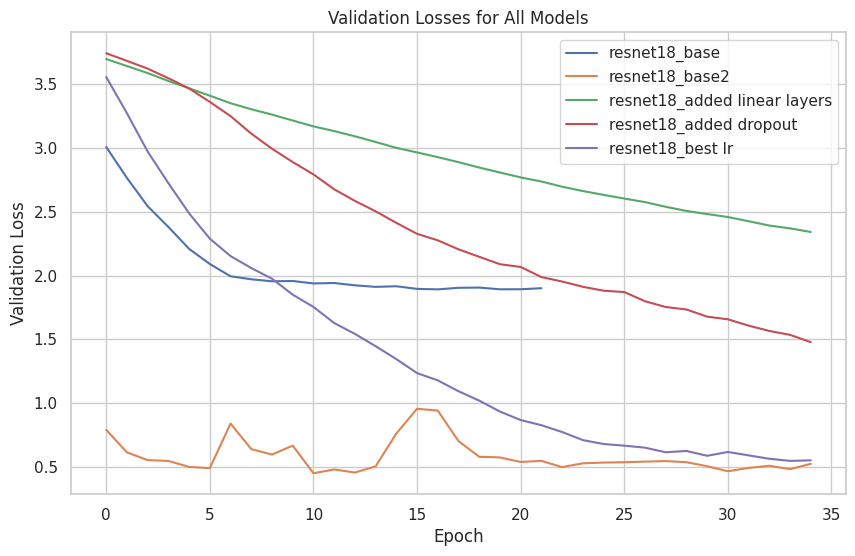

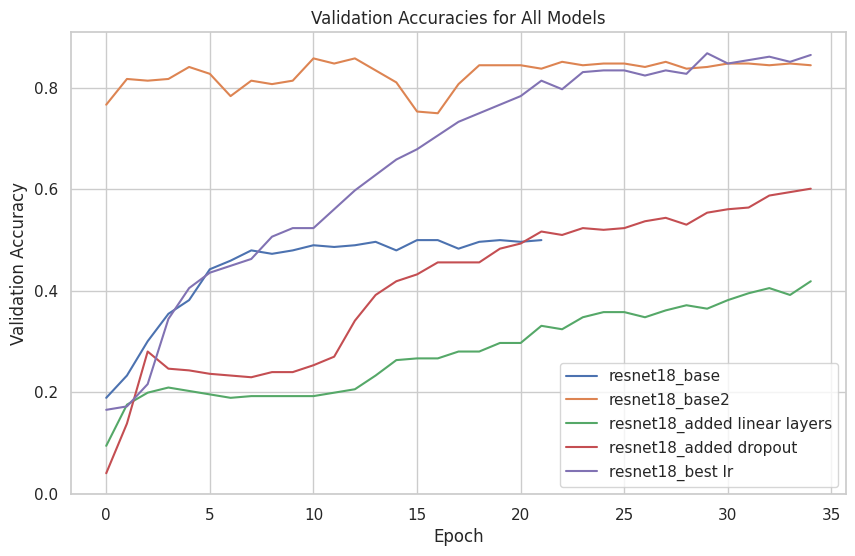

In [ ]:
plot_metrics(metrics)

### Fine tuning the best model

Until now we applied transfer learning. In this section we take the structure of the network that performed best, `resnet18_best_lr` and train it in its entirety, without freezing any layer.

In [14]:
cfg = {
    "resize_size": 256,
    "crop_size": 224,

    "batch_size": 32,
    "num_epochs": 25,

    "lr": 3e-4,
    "wd": 1e-4,
    "step_size": 5
}

In [15]:
num_classes = train_dataset.get_num_classes()

fine_tuned_model = resnet18(weights='IMAGENET1K_V1').to(device)

fine_tuned_model.fc = nn.Sequential(nn.Linear(fine_tuned_model.fc.in_features, 768),    # First additional layer
                                    nn.ReLU(),
                                    nn.Dropout(p = 0.6),                                # Activation function
                                    nn.Linear(768, 256),                                # Second additional layer
                                    nn.ReLU(),                                          # Activation function
                                    nn.Linear(256, num_classes)                         # Final layer to output num_classes
                                    ).to(device)

In [15]:
summary(fine_tuned_model, input_size=(3, 224, 224), device="cuda" if torch.cuda.is_available() else "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Through the summary we can see that the network has a total of **~11 million parameters**, and all of them are trainable. This means that the model is being updated from scratch during the training process.

In [28]:
model4, train_losses4, train_accuracies4, val_losses4, val_accuracies4 = train_model(fine_tuned_model, train_loader, val_loader, num_epochs = 35)

Epoch [1/35], Train Loss: 3.6852 Acc: 0.0932 | Val Loss: 3.5894 Acc: 0.2331
Epoch [2/35], Train Loss: 3.4316 Acc: 0.2519 | Val Loss: 3.3042 Acc: 0.2466
Epoch [3/35], Train Loss: 3.0400 Acc: 0.2864 | Val Loss: 2.9270 Acc: 0.3041
Epoch [4/35], Train Loss: 2.6500 Acc: 0.3326 | Val Loss: 2.6526 Acc: 0.3142
Epoch [5/35], Train Loss: 2.3360 Acc: 0.4163 | Val Loss: 2.4135 Acc: 0.3953
Epoch [6/35], Train Loss: 2.0784 Acc: 0.4875 | Val Loss: 2.2484 Acc: 0.4223
Epoch [7/35], Train Loss: 1.8913 Acc: 0.5182 | Val Loss: 2.1403 Acc: 0.4527
Epoch [8/35], Train Loss: 1.7354 Acc: 0.5409 | Val Loss: 2.0313 Acc: 0.4730
Epoch [9/35], Train Loss: 1.5813 Acc: 0.5841 | Val Loss: 1.8953 Acc: 0.5135
Epoch [10/35], Train Loss: 1.4487 Acc: 0.6167 | Val Loss: 1.8056 Acc: 0.5270
Epoch [11/35], Train Loss: 1.2973 Acc: 0.6545 | Val Loss: 1.7097 Acc: 0.5507
Epoch [12/35], Train Loss: 1.1883 Acc: 0.6996 | Val Loss: 1.6108 Acc: 0.5642
Epoch [13/35], Train Loss: 1.0643 Acc: 0.7383 | Val Loss: 1.5160 Acc: 0.5912
Epoch [1

The **validation set** reaches **83% of accuracy**, meaning that it does not perform as good as the previous model where we freezed the layers of the network's backbone.

In the last epochs we can see that the **validation loss** starts to go up and down, meaning that with more epochs we could start to overfit the dataset.

In [31]:
display_markdown("## resnet18_fine_tuned Test Set Accuracy")
evaluate_model(model4)

## resnet18_fine_tuned Test Set Accuracy

Test Loss: 0.4460, Test Accuracy: 87.08%

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
save_path = '/content/drive/MyDrive/AssignmentsIPCV/resnet18_fine_tuned.pth'

# Save the model state dictionary (weights)
torch.save(model4.state_dict(), save_path)

In [36]:
metrics = []

In [37]:
metrics.append({
    "model_name": "resnet18_fine_tuned",
    "train_losses": train_losses4,
    "train_accuracies": train_accuracies4,
    "val_losses": val_losses4,
    "val_accuracies": val_accuracies4
})

In [38]:
import pandas as pd
df_metrics = pd.DataFrame(metrics)

Finally, we plot also the **validation set** *accuracy* and *loss* of the fine-tuned model.

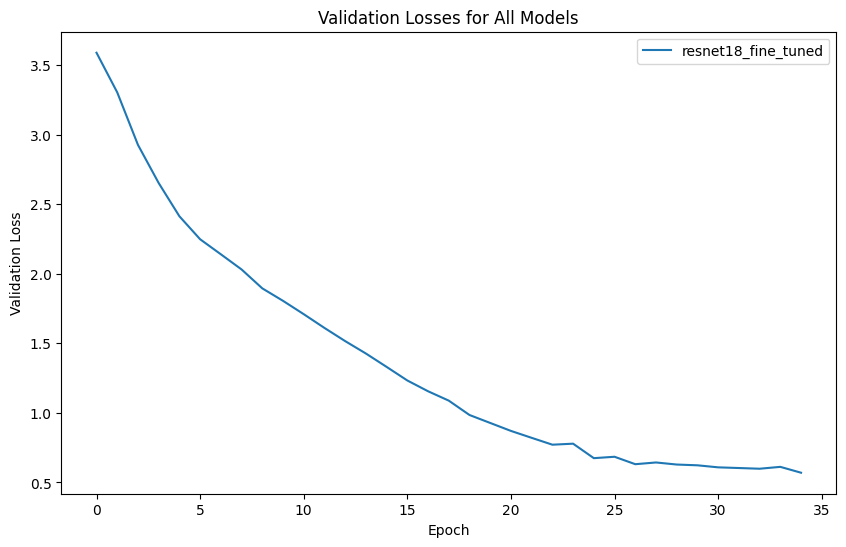

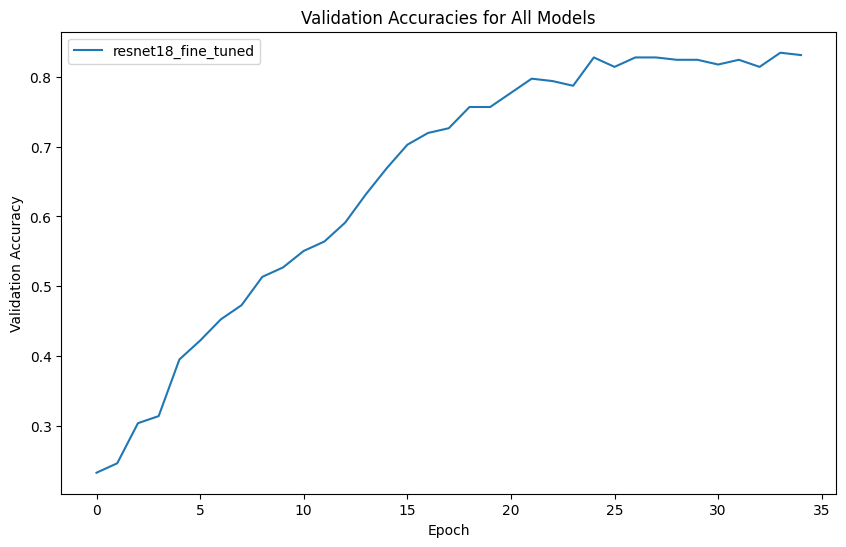

In [39]:
plot_metrics(metrics)

#### Sample of the Image Classifications

In this section we show that the model accurately predicted the class of most images in the test set. However, it misclassified a few images, likely due to factors such as occlusion, poor lighting, or unusual variations in the object's appearance.

**Load the weights**

In [16]:
# Load the previously saved weights
checkpoint_path = '/content/drive/MyDrive/AssignmentsIPCV/resnet18_fine_tuned.pth'
fine_tuned_model.load_state_dict(torch.load(checkpoint_path))

# Set the model to evaluation mode
fine_tuned_model.eval()

<ipython-input-16-6f915c1f3b82>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fine_tuned_model.load_state_dict(torch.load(checkpoint_path))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**Define the inference function** that we use to perform inference (a forward pass) through the loaded model

In [34]:
def inference(img):
    with torch.no_grad():
        output = fine_tuned_model(img)  # Forward pass

    # Get the predicted class
    _, predicted_class = torch.max(output, 1)

    print(f"Predicted class index: {predicted_class.item()}")
    return predicted_class


**Define the mapping between Predicted Class and Predited Label**

In [35]:
def map_class(predicted_class):
    class_labels = ["Apple", "Avocado", "Banana", "Kiwi", "Lemon", "Lime", "Mango", "Melon", "Nectarine", "Orange", "Papaya", "Passion-Fruit", "Peach", "Pear", "Pineapple", "Plum", "Pomegranate", "Red-Grapefruit", "Satsumas", "Juice", "Milk", "Oatghurt", "Oat-Milk", "Sour-Cream", "Sour-Milk", "Soyghurt", "Soy-Milk", "Yoghurt", "Asparagus", "Aubergine", "Cabbage", "Carrots", "Cucumber", "Garlic", "Ginger", "Leek", "Mushroom", "Onion", "Pepper", "Potato", "Red-Beet", "Tomato", "Zucchini"]

    # Label corresponding to the predicted class
    predicted_label = class_labels[predicted_class.item()]

    print(f"Predicted class: {predicted_label}")

**Pre-process of the images**

In [ ]:
# Defining transformations for the data
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),                                                  # Resizing to 224x224
    transforms.ToTensor(),                                                          # Converting to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])     # Normalizing with the same ImageNet means and stds
])

**Inferences!**

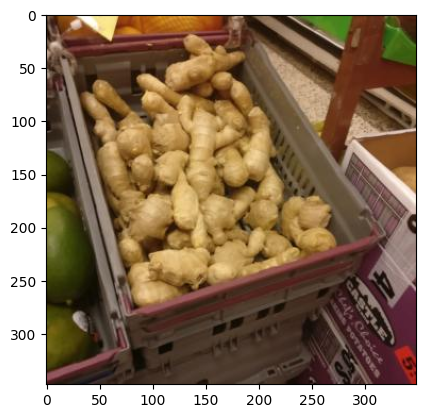

Image size after preprocessing: torch.Size([1, 3, 224, 224])
Predicted class index: 34
Predicted class: Ginger


In [44]:
# Load and preprocess the image
img_path1 = '/content/GroceryStoreDataset/dataset/test/Vegetables/Ginger/Ginger_003.jpg'
img1 = Image.open(img_path1)

plt.imshow(img1)
plt.show()

# Transform the image
img1 = transform(img1)

# Add batch dimension (since the model expects a batch of inputs)
img1 = img1.unsqueeze(0).to(device)  # Convert to batch with a single image

# Confirm the image size and format
print("Image size after preprocessing:", img1.size())

# Inference
pr_class1 = inference(img1)
map_class(pr_class1)

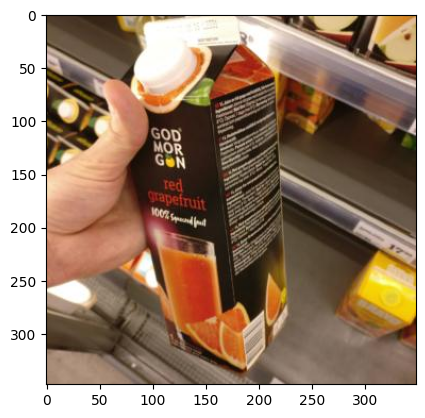

Image size after preprocessing: torch.Size([1, 3, 224, 224])
Predicted class index: 19
Predicted class: Juice


In [45]:
img_path2 = '/content/GroceryStoreDataset/dataset/test/Packages/Juice/God-Morgon-Red-Grapefruit-Juice/God-Morgon-Red-Grapefruit-Juice_007.jpg'
img2 = Image.open(img_path2)

plt.imshow(img2)
plt.show()

img2 = transform(img2)
img2 = img2.unsqueeze(0).to(device)
print("Image size after preprocessing:", img2.size())

pr_class2 = inference(img2)
map_class(pr_class2)

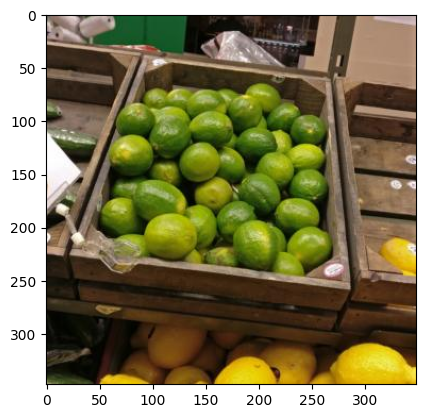

Image size after preprocessing: torch.Size([1, 3, 224, 224])
Predicted class index: 5
Predicted class: Lime


In [49]:
img_path3 = '/content/GroceryStoreDataset/dataset/test/Fruit/Lime/Lime_005.jpg'
img3 = Image.open(img_path3)

plt.imshow(img3)
plt.show()

img3 = transform(img3)
img3 = img3.unsqueeze(0).to(device)
print("Image size after preprocessing:", img3.size())

pr_class3 = inference(img3)
map_class(pr_class3)